In [70]:
from cost_wiz.db import Instance, InstanceStat
import pandas as pd
from darts import TimeSeries
from cost_wiz.config.settings import EnvSettings
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base

env: EnvSettings = EnvSettings()

# Directly define the database connection string
DATABASE_URL = f"postgresql://{env.db_username}:{env.db_password}@{env.db_host_name}:{env.db_port}/{env.db_name}"

engine = create_engine(DATABASE_URL, echo=True)
SessionLocal = sessionmaker(autocommit=False, autoflush=False, bind=engine)
Base = declarative_base()
session = SessionLocal()

In [71]:
# Perform a join between Instance and InstanceStat, filtering for t3.micro instance type
instance_stats = session.query(
    Instance.instance_type,
    InstanceStat.timestamp,
    InstanceStat.max_cpu_usage,
    InstanceStat.max_mem_usage,
).join(InstanceStat, Instance.instance_id == InstanceStat.instance_id)\
 .filter(Instance.instance_type == "t3.micro")\
 .all()
session.close()
# Convert query results to a Pandas DataFrame
df = pd.DataFrame(instance_stats, columns=["instance_name", "timestamp", "max_cpu_usage", "max_mem_usage"])
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['timestamp'] = df['timestamp'].dt.floor('H')
df.head()

2024-04-06 21:55:21,500 INFO sqlalchemy.engine.Engine select pg_catalog.version()
2024-04-06 21:55:21,502 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-06 21:55:22,223 INFO sqlalchemy.engine.Engine select current_schema()
2024-04-06 21:55:22,224 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-06 21:55:22,803 INFO sqlalchemy.engine.Engine show standard_conforming_strings
2024-04-06 21:55:22,805 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-06 21:55:23,455 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-06 21:55:23,459 INFO sqlalchemy.engine.Engine SELECT instance.instance_type AS instance_instance_type, instance_stats.timestamp AS instance_stats_timestamp, instance_stats.max_cpu_usage AS instance_stats_max_cpu_usage, instance_stats.max_mem_usage AS instance_stats_max_mem_usage 
FROM instance JOIN instance_stats ON instance.instance_id = instance_stats.instance_id 
WHERE instance.instance_type = %(instance_type_1)s
2024-04-06 21:55:23,460 INFO sqlalchemy.engine.Engine

,instance_name,timestamp,max_cpu_usage,max_mem_usage
0,t3.micro,2022-04-05 15:00:00,34.538212,58.025048
1,t3.micro,2022-04-05 16:00:00,64.905463,56.543621
2,t3.micro,2022-04-05 17:00:00,73.656384,56.276776
3,t3.micro,2022-04-05 18:00:00,39.680856,18.028086
4,t3.micro,2022-04-05 19:00:00,19.745643,28.012249


In [72]:
df = df.drop_duplicates(subset='timestamp')

In [73]:
df.set_index('timestamp', inplace=True)

In [74]:
idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df = df.reindex(idx)

In [75]:
df

,instance_name,max_cpu_usage,max_mem_usage
2022-04-05 15:00:00,t3.micro,34.538212,58.025048
2022-04-05 16:00:00,t3.micro,64.905463,56.543621
2022-04-05 17:00:00,t3.micro,73.656384,56.276776
2022-04-05 18:00:00,t3.micro,39.680856,18.028086
2022-04-05 19:00:00,t3.micro,19.745643,28.012249
...,...,...,...
2023-04-05 11:00:00,t3.micro,14.381090,31.629587
2023-04-05 12:00:00,t3.micro,9.155604,79.261359
2023-04-05 13:00:00,t3.micro,70.445576,66.141116
2023-04-05 14:00:00,t3.micro,43.516431,26.458243


In [76]:
from darts.utils.timeseries_generation import gaussian_timeseries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import AutoARIMA
from darts.models.forecasting.transformer_model import TransformerModel
from darts.utils.statistics import check_seasonality, plot_acf

train_size = int(len(df) * 0.9)
ts_train = df['max_cpu_usage'][:train_size]
ts_valid = df['max_cpu_usage'][train_size:]

train_series = TimeSeries.from_series(ts_train)
valid_series = TimeSeries.from_series(ts_valid)

model = TransformerModel(input_chunk_length=10, output_chunk_length=10)
model.fit(train_series)

/home/leapfrog/anaconda3/envs/cost-wizards-be/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Nam

Epoch 99: 100%|██████████| 219/219 [00:03<00:00, 68.94it/s, train_loss=421.0] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 219/219 [00:03<00:00, 68.92it/s, train_loss=421.0]


TransformerModel(output_chunk_shift=0, d_model=64, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=10, output_chunk_length=10)

In [77]:
# Make predictions on the validation set
len(valid_series)
predictions = model.predict(len(valid_series))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


In [78]:
from darts.metrics import mape, mase

m_a_p_e = mape(valid_series, predictions)
m_a_s_e = mase(valid_series, predictions, train_series)

In [79]:
m_a_p_e

77.43405153821533

In [80]:
m_a_s_e

0.7429921183407427

<Axes: xlabel='time'>

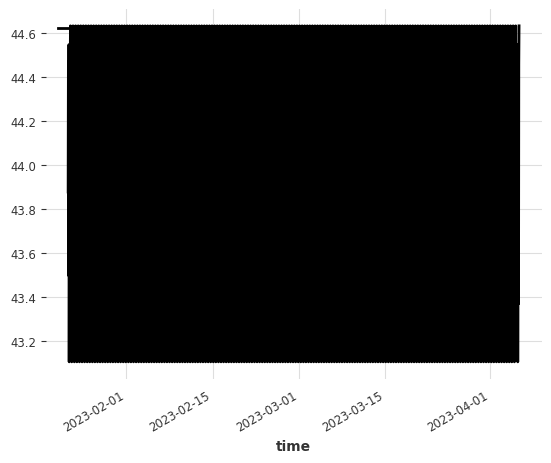

In [81]:
predictions.plot()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


<Axes: xlabel='time'>

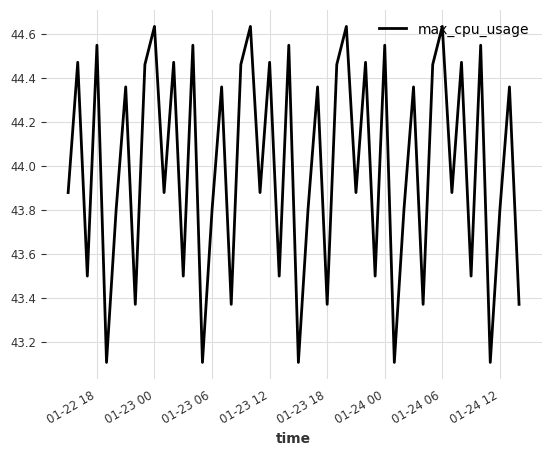

In [89]:
predict = model.predict(n=1801)
predict[:48].plot()

In [83]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(time, data1, label='Line 1')
plt.plot(time, data2, label='Line 2')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.legend()
plt.grid(True)
plt.show()

1753

In [90]:
model.save('time_series.pt')